# MNIST from scratch with numpy

In [1]:
# load changed modules automatically
%reload_ext autoreload
%autoreload 2

In [89]:
# load numpy
import numpy as np

# load dataloaders and required layers
from mnist import dataloader
from mnist.layers import Softmax, Linear
from mnist.losses import CrossEntropy

# load pyplot for displaying images
from matplotlib import pyplot as plt

# show images inline on notebook
%matplotlib inline

# debugging
import pdb

## Load training data

In [3]:
dl = dataloader.DataLoader()
((x_train, y_train), (x_valid, y_valid), (x_test, (y_test))) = dl.load_data()

In [4]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

## Normalize data

In [5]:
(x_train, y_train), (x_valid, y_valid) = dl.normalize(((x_train, y_train), (x_valid, y_valid)))

## Exploring the data

In [16]:
def show(img):
    plt.imshow(img, cmap="gray")

In [7]:
valid_images = np.reshape(x_valid, (-1,28,28))

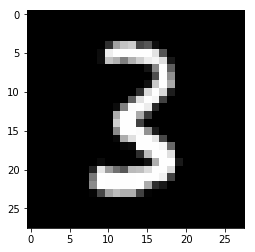

In [8]:
show(valid_images[0])

## Start building the model

In [6]:
def shuffle(arr1, arr2):
    random_idxs = np.arange(len(arr1))
    np.random.shuffle(random_idxs)
    return x_train[random_idxs], y_train[random_idxs]

def dropout(X, drop_probability):
    keep_probability = 1 - drop_probability
    mask = np.random.uniform(0, 1.0, X.shape) < keep_probability
    scale = (1/keep_probability)
    return mask * X * scale

In [93]:
# always reproduce the same weights
np.random.seed(1)

class Net():
    def __init__(self):
        self.input_layer = Linear(28*28, 10) # linear layer with bias
        self.softmax = Softmax()
        self.cross_entropy = CrossEntropy()
    
    def forward(self, x):
        x = self.input_layer.forward(x)
        x = self.softmax.forward(x)
        return x
    
    def backward(self, predictions, y):
        grad_loss = net.softmax.backward(predictions, y)
        grad_input_layer, grad_bias = net.input_layer.backward(inputs, grad_loss)
        return grad_input_layer, grad_bias
    
    def loss(self, y_pred, y):
        return self.cross_entropy.loss(y_pred, y)

net = Net()

In [94]:
debug = False

if debug:
    n_epochs = 1
    batch_size = 8
else:
    n_epochs = 50
    batch_size = 512
    
learning_rate = 1e-1

for epoch in range(n_epochs):
    
    for i in range(0, len(x_train), batch_size):

        inputs = x_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]
        
        inputs, targets = shuffle(inputs, targets)

        if debug:
            print("inputs.shape", inputs.shape)
            print("targets.shape", targets.shape)

        # forward propagation
        y_pred = net.forward(inputs)
        predictions = y_pred.copy()

        if debug:
            print("y_pred.shape:", y_pred.shape)
            print("predictions.shape", predictions.shape)
            
        # calculate cross-entropy loss
        loss = net.loss(predictions, targets)
        
        if debug:
            print(epoch, loss)
        
        # backpropagation        
        grad_input_layer, grad_bias = net.backward(predictions, targets)
        
        if debug:
            print("grad_input_layer.shape", grad_input_layer.shape)
            print("net.input_layer.weights.shape", net.input_layer.weights.shape)
            print("net.input_layer.bias.shape", net.input_layer.bias.shape)
        
        net.input_layer.weights -= learning_rate * grad_input_layer.T
        net.input_layer.bias -= learning_rate * grad_bias
        
        if debug:
            break
        
    # calculate validation loss for some random indices
    random_idxs = np.random.randint(0, len(x_valid), batch_size)
    y_valid_pred = net.forward(x_valid[random_idxs])
    loss_valid = net.loss(y_valid_pred, y_valid[random_idxs])
    
    #calculate accuracy and validation accuracy
    accuracy = np.mean(y_pred.argmax(axis=1) == targets)
    valid_accuracy = np.mean(y_valid_pred.argmax(axis=1) == y_valid[random_idxs])
    
    print(epoch, loss, loss_valid, accuracy, valid_accuracy)


0 2.0572343174261296 2.0803794741323727 0.625 0.58984375
1 1.8403301856652743 1.8991903883389245 0.6994047619047619 0.650390625
2 1.6606222009313545 1.7626918655225627 0.7351190476190477 0.65625
3 1.511733665956536 1.6216523423611875 0.7619047619047619 0.689453125
4 1.3879209119293223 1.5075813802012277 0.7767857142857143 0.712890625
5 1.28424956232271 1.3942257185682791 0.7976190476190477 0.716796875
6 1.1967100305030716 1.363744374804816 0.8125 0.703125
7 1.1221279294066313 1.2844169653438957 0.8214285714285714 0.72265625
8 1.0580156556677234 1.2118638134412367 0.8244047619047619 0.759765625
9 1.0024269184893402 1.1762918560765574 0.8333333333333334 0.763671875
10 0.9538340195587379 1.1351382096501557 0.8392857142857143 0.755859375
11 0.911030791329668 1.0924171449119786 0.8422619047619048 0.75390625
12 0.8730580922096739 1.0500709919342293 0.8422619047619048 0.78125
13 0.8391473323502381 1.021137212205017 0.8511904761904762 0.771484375
14 0.8086778023323252 1.0410814759147609 0.8601

## Check results

In [95]:
# get some random examples from validation data,
# compare predictions with actual values
valid_preds = net.forward(x_valid)
random_idxs = np.random.randint(0, len(x_valid), 10)
np.argmax(valid_preds, axis=1)[random_idxs], y_valid[random_idxs]

(array([4, 8, 1, 4, 3, 4, 4, 0, 1, 2]), array([4, 8, 1, 4, 3, 8, 4, 0, 8, 2]))

prediction: 2 correct: 2


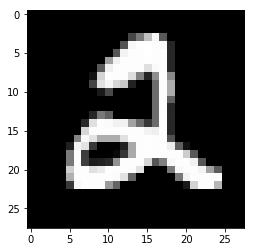

In [99]:
# display a random image from validation data with
# prediction and correct value
valid_images = np.reshape(x_valid, (-1,28,28))
valid_preds = net.forward(x_valid)
random_idx = np.random.randint(0, len(x_valid))
prediction = np.argmax(valid_preds, axis=1)[random_idx]
correct = y_valid[random_idx]
print("prediction:", prediction, "correct:", correct)
show(valid_images[random_idx])